In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

In [48]:
df = pd.read_csv("../data/car_sales_date_company_ohe.csv")

In [49]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
date_column = df['Date']
df.drop(columns=['Date'], inplace=True)

le = LabelEncoder()
df['Company'] = le.fit_transform(df['Company'])

In [50]:
df["Company"].head(32)

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    16
14    17
15    18
16    19
17    23
18    25
19    26
20    27
21    28
22     0
23     1
24     2
25     3
26     4
27     5
28     6
29     7
30    16
31    17
Name: Company, dtype: int64

In [51]:
df

,Company,Total_Sales,Sales_Count,Model_3-9,Model_3000GT,Model_300M,Model_323i,Model_328i,Model_4Runner,Model_5-9,...,Dealer_Region_Aurora,Dealer_Region_Austin,Dealer_Region_Greenville,Dealer_Region_Janesville,Dealer_Region_Middletown,Dealer_Region_Pasco,Dealer_Region_Scottsdale,Year,Month,Day
0,0,55500,2,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,2022,1,2
1,1,12000,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,2022,1,2
2,2,15000,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,2022,1,2
3,3,19000,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,2022,1,2
4,4,62500,2,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,2022,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10484,22,43000,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,2023,12,31
10485,24,26000,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,2023,12,31
10486,26,49000,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,2023,12,31
10487,27,49001,2,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,2023,12,31


In [52]:
X = df.drop(columns=['Sales_Count']) 
y = df['Sales_Count'] 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [55]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0)
    }

    model = xgb.XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse 

In [56]:
study = optuna.create_study(direction="minimize")  
study.optimize(objective, n_trials=50)

print("Best Hyperparameters:", study.best_params)

best_params = study.best_params
final_model = xgb.XGBRegressor(**best_params, random_state=42)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Final RMSE: {rmse}")

[I 2025-02-06 13:29:25,831] A new study created in memory with name: no-name-6b290370-58b4-47cd-9e07-ebe285d4ccc2
/var/folders/p2/kz7q7x7x42g49d80lqbllfy00000gn/T/ipykernel_29402/2689505123.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/p2/kz7q7x7x42g49d80lqbllfy00000gn/T/ipykernel_29402/2689505123.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
/var/folders/p2/kz7q7x7x42g49d80lqbllfy00000gn/T/ipykernel_29402/2689505123.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https:/

Best Hyperparameters: {'n_estimators': 202, 'max_depth': 3, 'learning_rate': 0.17950304645439574, 'subsample': 0.8909635572120078, 'colsample_bytree': 0.6339857562842438, 'reg_alpha': 0.779291701598637, 'reg_lambda': 0.0066120010389741565}
Final RMSE: 0.06601142454000374


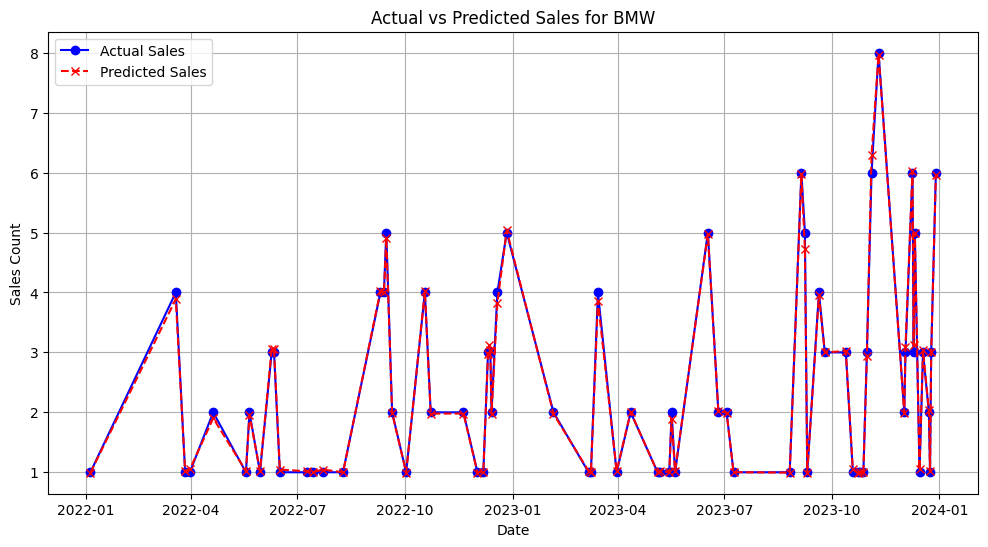

In [64]:
company_name = "BMW"
company_encoded = le.transform([company_name])[0]


company_mask = X_test['Company'] == company_encoded
actual_sales = y_test[company_mask]
predicted_sales = y_pred[company_mask]
dates = date_column.loc[X_test.index[company_mask]]

sorted_indices = np.argsort(dates.values)
dates = dates.iloc[sorted_indices].values
actual_sales = np.array(actual_sales)[sorted_indices]
predicted_sales = np.array(predicted_sales)[sorted_indices]


plt.figure(figsize=(12, 6))
plt.plot(dates, actual_sales, label="Actual Sales",
         marker="o", linestyle="-", color="blue")
plt.plot(dates, predicted_sales, label="Predicted Sales",
         marker="x", linestyle="--", color="red")
plt.xlabel("Date")
plt.ylabel("Sales Count")
plt.title(f"Actual vs Predicted Sales for {company_name}")
plt.legend()
plt.grid()
plt.show()